Project root on sys.path: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS
Loaded simulation module from: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS/model/simulation.py


/Users/andregrau/Desktop/Thesis/Python_Tool/simLIS/model/simulation.py:82: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataframe[datetime_column_name] = pd.to_datetime(dataframe[datetime_column_name], errors="coerce")
/Users/andregrau/Desktop/Thesis/Python_Tool/simLIS/model/simulation.py:82: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataframe[datetime_column_name] = pd.to_datetime(dataframe[datetime_column_name], errors="coerce")


2025-06-04 00:00:00 None


PV lokal Peak [kW]: 0.0
PV DE Peak [GW]: 0.0

Verwendetes Szenario: office
Ladepunkte: 5
Zeitraum: 2025-06-04 00:00:00 bis 2025-06-04 23:45:00
Horizont: 1 Tage

📊 Sessions
Ankünfte mit Ladebedarf: 16
mit Ladezugang: 7
ohne Ladezugang (drive_off): 9
Alle BEV haben Ziel-SoC erreicht.
Daytypes: {'working_day': 1, 'saturday': 0, 'sunday_holiday': 0}


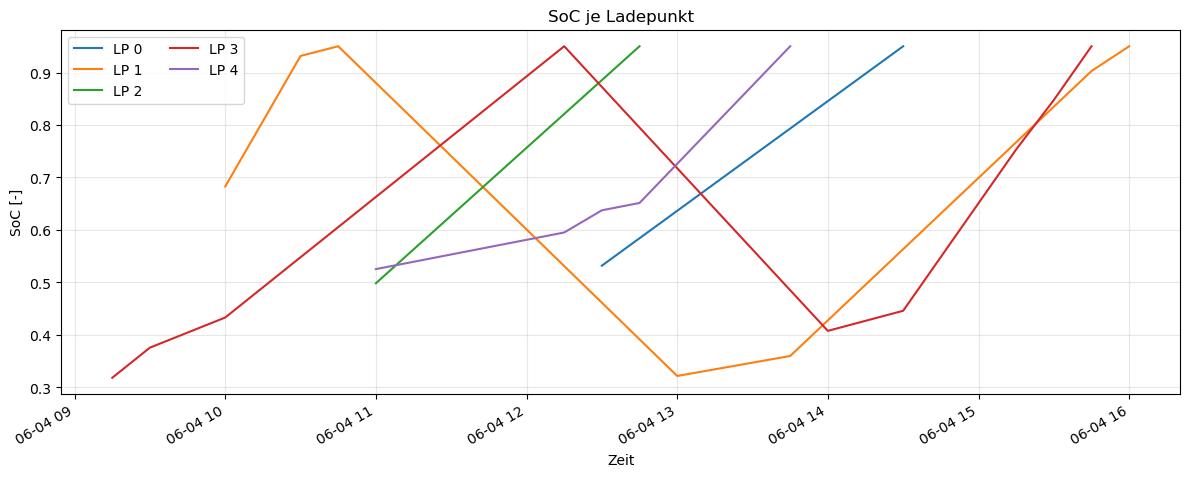

Verstöße: 0


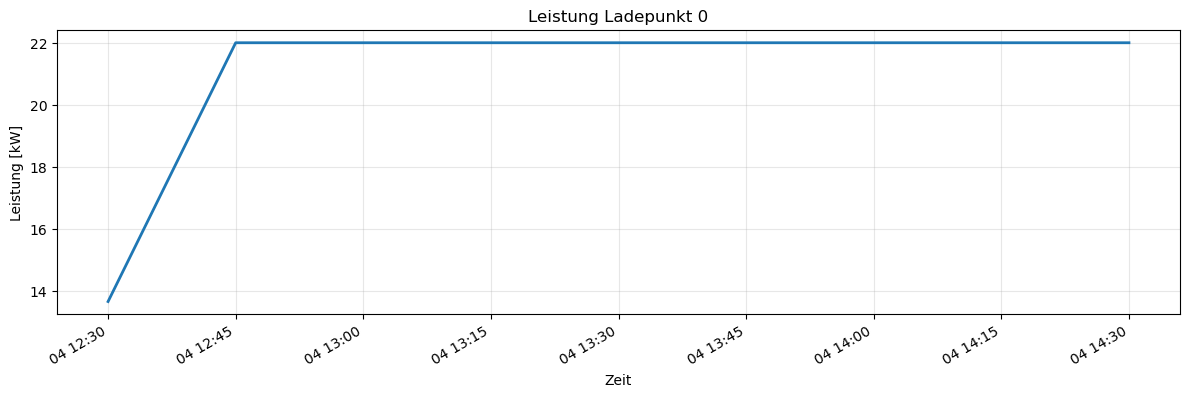

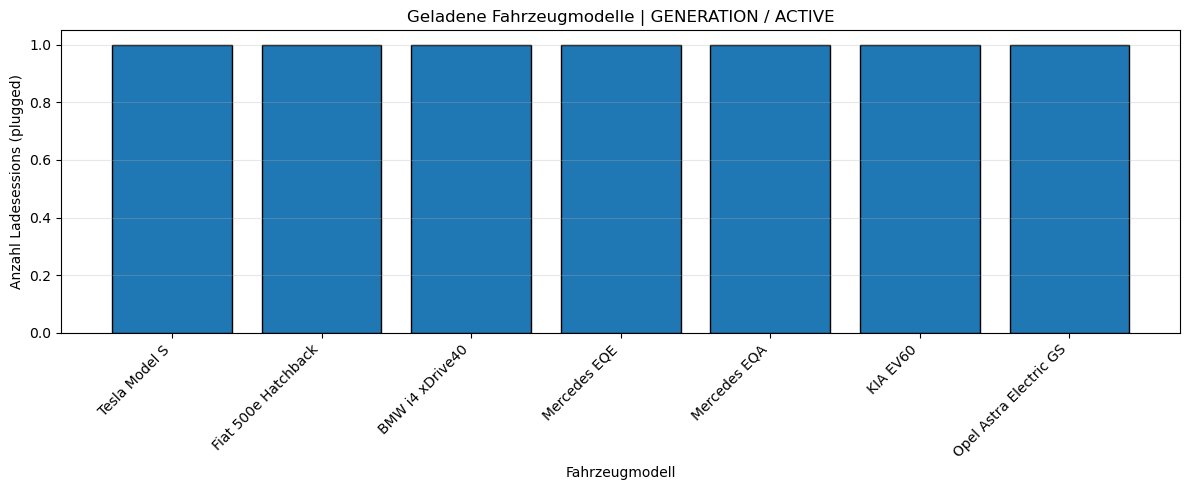

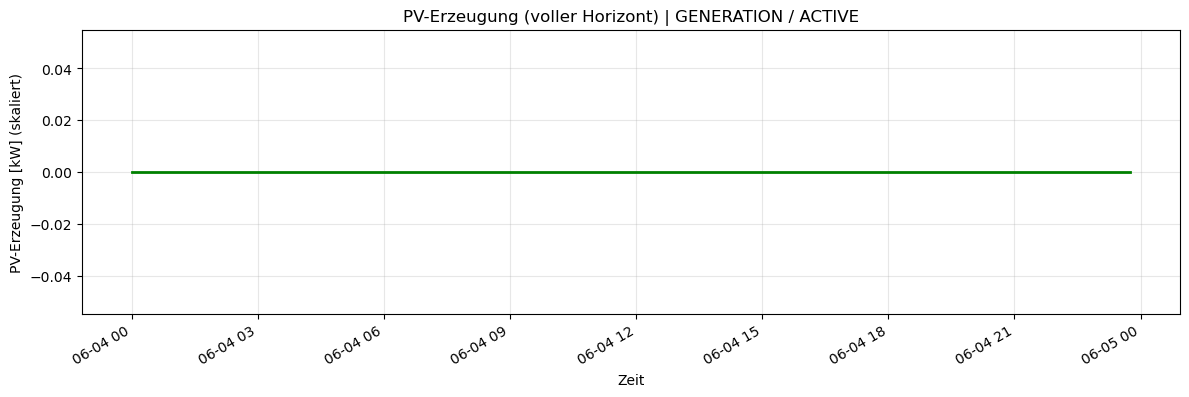

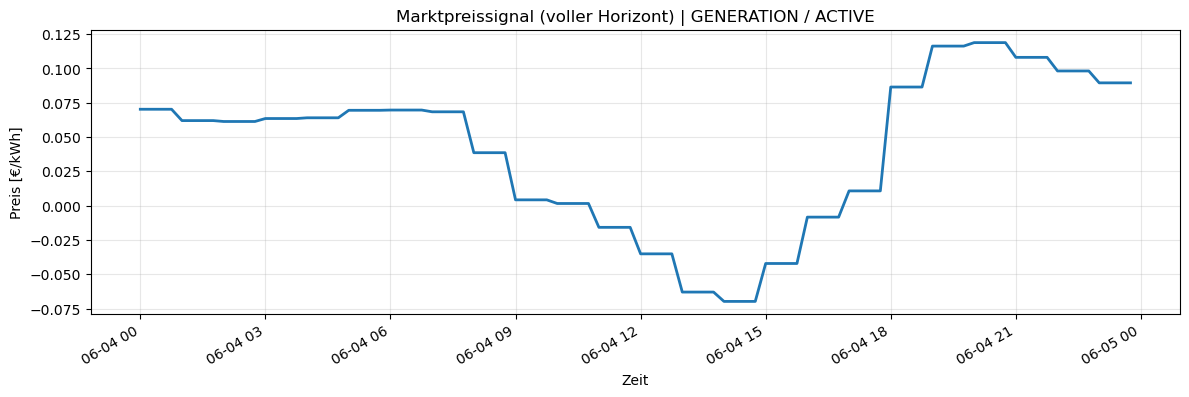

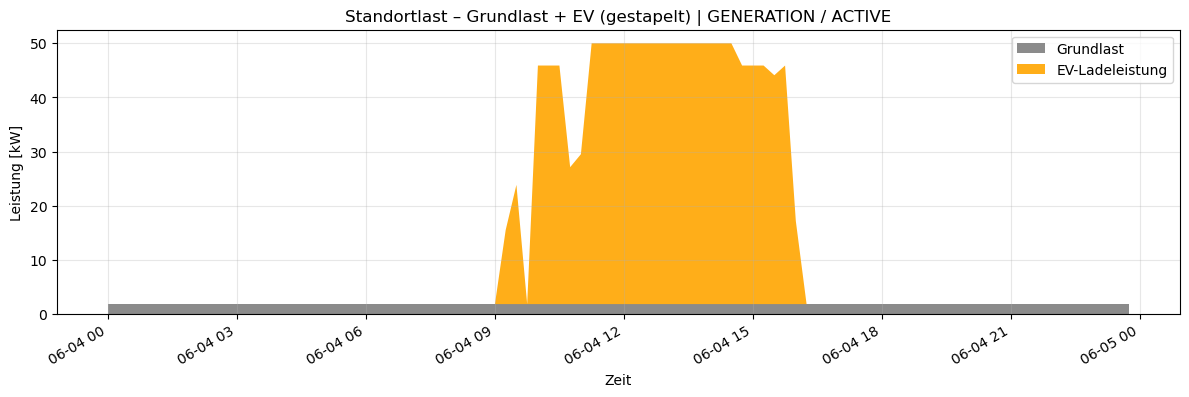

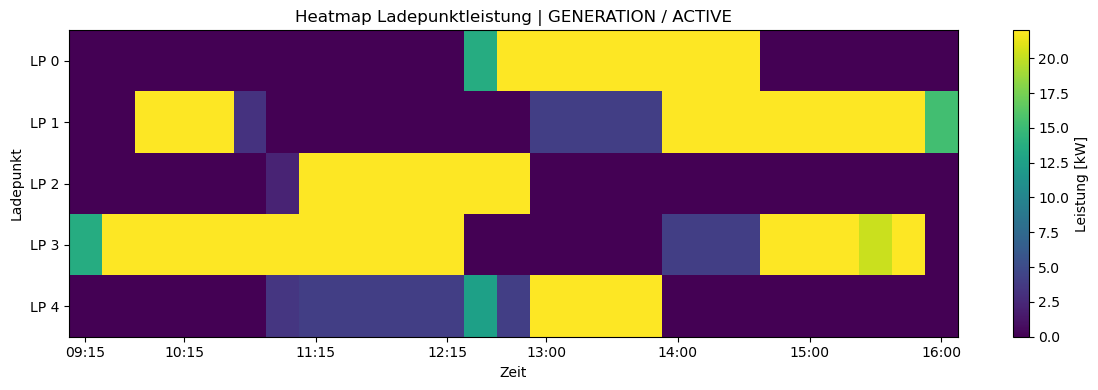

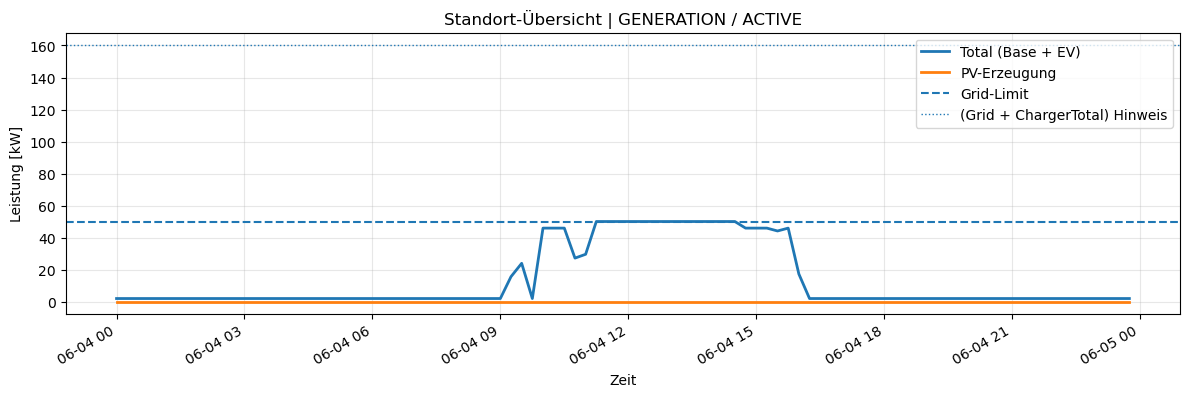

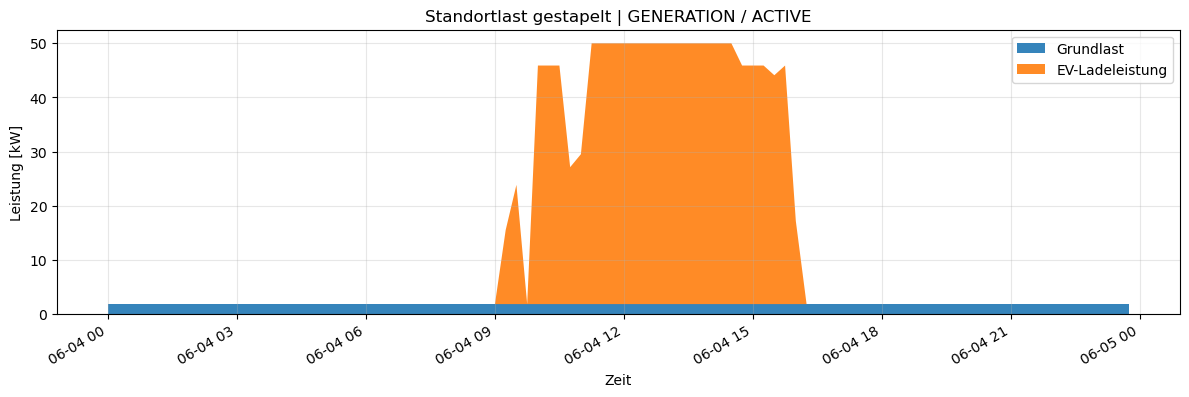

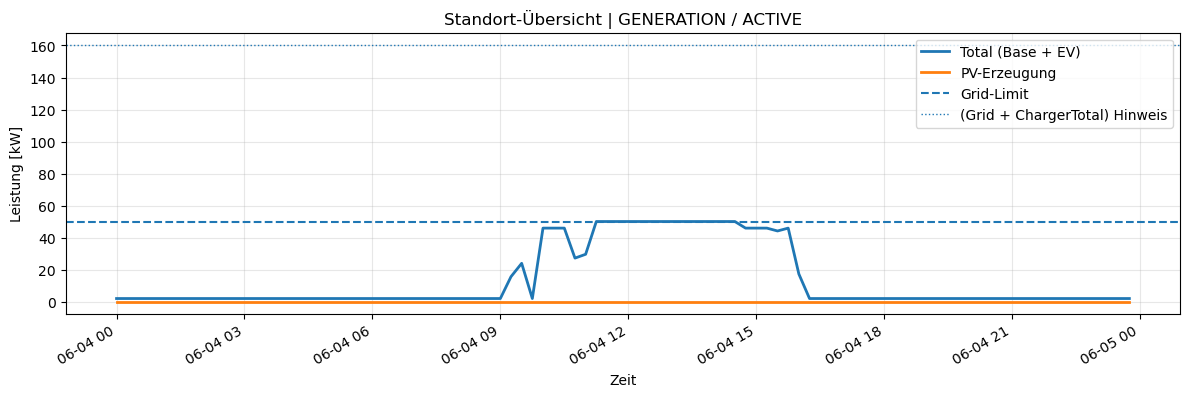

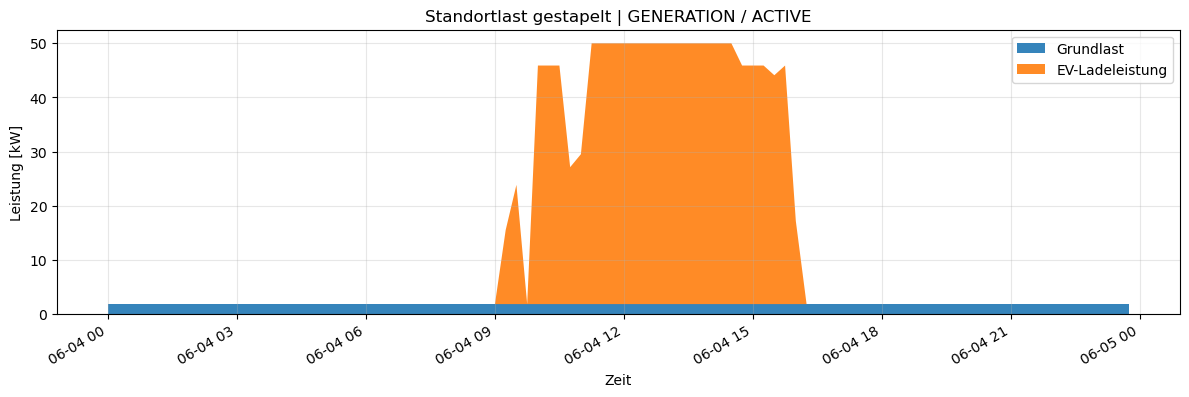

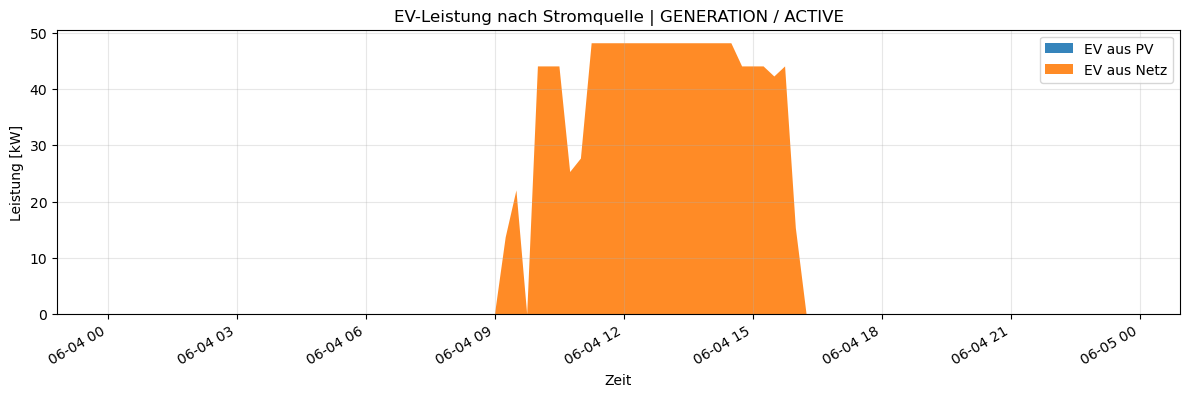

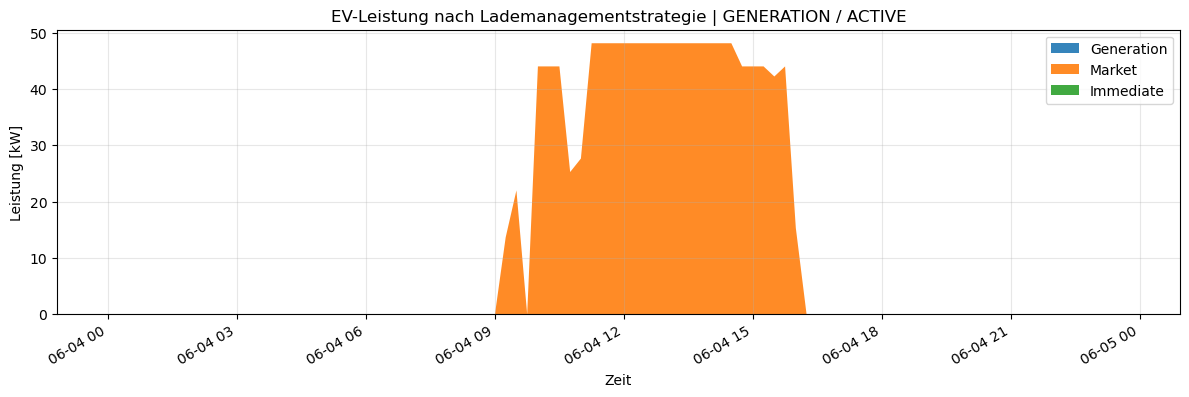

,session_id,charger_id,vehicle_name,arrival_time,departure_time,state_of_charge_at_arrival,state_of_charge_end,charged_site_kwh,charged_pv_site_kwh,charged_market_site_kwh,charged_immediate_site_kwh,remaining_site_kwh
0,2025-06-04_000_00004,0,Tesla Model S,2025-06-04 07:00:00,2025-06-04 14:45:00,0.499587,0.95,47.411932,0.0,47.411932,0.0,0.0
1,2025-06-04_000_00009,1,Fiat 500e Hatchback,2025-06-04 07:30:00,2025-06-04 11:00:00,0.558388,0.95,17.313365,0.0,17.313365,0.0,0.0
2,2025-06-04_000_00012,2,BMW i4 xDrive40,2025-06-04 07:30:00,2025-06-04 13:00:00,0.492032,0.95,39.047760,0.0,39.047760,0.0,0.0
3,2025-06-04_000_00010,3,Mercedes EQE,2025-06-04 07:45:00,2025-06-04 12:30:00,0.282756,0.95,63.914927,0.0,63.914927,0.0,0.0
4,2025-06-04_000_00011,4,Mercedes EQA,2025-06-04 07:45:00,2025-06-04 14:00:00,0.513709,0.95,32.147776,0.0,32.147776,0.0,0.0
5,2025-06-04_000_00006,1,KIA EV60,2025-06-04 11:45:00,2025-06-04 19:30:00,0.309165,0.95,51.941374,0.0,51.941374,0.0,0.0
6,2025-06-04_000_00008,3,Opel Astra Electric GS,2025-06-04 12:45:00,2025-06-04 19:00:00,0.388627,0.95,30.136885,0.0,30.136885,0.0,0.0


In [1]:
# =============================================================================
# A) Scenario Setup
# =============================================================================
scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"

# Zoom-Fenster (Tage ab Start) – 1 = erster Tag
ZOOM_DAYS = 1

# Reproduzierbarkeit (optional)
RANDOM_SEED = 42

# =============================================================================
# B) Imports + Farben
# =============================================================================
import os
import sys
import warnings
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display, HTML

warnings.simplefilter("always", UserWarning)

# Plot-Farben (global konsistent)
COLOR_GENERATION = "green"      # PV / generation
COLOR_MARKET     = "tab:blue"   # market
COLOR_IMMEDIATE  = "orange"     # immediate
COLOR_GRID       = "orange"     # EV aus Netz (bleibt orange)
COLOR_LOAD       = "orange"     # Standortlast-Fläche (wie gehabt)
COLOR_BASELOAD   = "#7f7f7f"
COLOR_TOTAL      = "black"      # Summenlinie

# =============================================================================
# C) Notebook UI Helpers (wie vorher)
# =============================================================================
def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    color_map = {"ACTIVE": "#1a7f37", "INACTIVE": "#c62828", "IMMEDIATE": "#616161"}
    emoji_map = {"ACTIVE": "🟢", "INACTIVE": "🔴", "IMMEDIATE": "⚪"}
    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")

    html = f"""
    <div style="font-size:18px;font-weight:800;color:{color};
                padding:10px 12px;border:2px solid {color};border-radius:12px;
                display:flex;align-items:center;gap:10px;width:fit-content;
                margin:8px 0 14px 0; background: rgba(0,0,0,0.02);">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>
    """
    display(HTML(html))

def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title} | {strat} / {status}"

def init_time_window(timestamps, scenario: dict, days: int = 1):
    """Zoom-Fenster (t0, t1) basierend auf Zeitschrittauflösung."""
    if timestamps is None or len(timestamps) == 0:
        return None, None, None
    steps_per_day_local = int(24 * 60 / int(scenario["time_resolution_min"]))
    steps = int(max(1, days)) * steps_per_day_local
    t0_local = pd.to_datetime(timestamps[0])
    t1_local = pd.to_datetime(timestamps[min(len(timestamps) - 1, steps - 1)])
    return steps_per_day_local, t0_local, t1_local

# =============================================================================
# D) Projektpfad robust setzen + Simulation-Modul robust importieren
# =============================================================================
def ensure_project_root_on_syspath():
    """Fügt das Projekt-Root (Ordner, der 'model/' enthält) nach sys.path[0] hinzu."""
    cwd = Path.cwd().resolve()
    candidates = [cwd] + list(cwd.parents)

    for p in candidates:
        if (p / "model").exists() and (p / "model").is_dir():
            root = str(p)
            if root not in sys.path:
                sys.path.insert(0, root)
            return root

    fallback = str((cwd / "..").resolve())
    if fallback not in sys.path:
        sys.path.insert(0, fallback)
    return fallback

project_root = ensure_project_root_on_syspath()
print("Project root on sys.path:", project_root)

# --- Robust: lade das Modul direkt aus der Datei (kein Ärger mit Modulnamen) ---
import importlib.util

SIM_MODULE_PATH = Path(project_root) / "model" / "simulation.py"   # <-- falls dein File anders heißt: anpassen
if not SIM_MODULE_PATH.exists():
    # Fallback: manchmal liegt die Datei direkt neben dem Notebook
    SIM_MODULE_PATH = Path.cwd().resolve() / "simulation.py"

spec = importlib.util.spec_from_file_location("simulation_module", SIM_MODULE_PATH)
sim = importlib.util.module_from_spec(spec)

# Wichtig für Python 3.12/3.13 + @dataclass: Modul vor exec_module in sys.modules registrieren
sys.modules[spec.name] = sim

spec.loader.exec_module(sim)

print("Loaded simulation module from:", SIM_MODULE_PATH)

# =============================================================================
# E) Notebook-kompatible Adapter-Funktionen (Mapping alt -> neu)
# =============================================================================

# 1) Alt: load_scenario -> Neu: read_scenario_from_yaml
load_scenario = sim.read_scenario_from_yaml

# 2) Alt: make_timeseries_df -> Neu: build_timeseries_dataframe
def make_timeseries_df(
    timestamps,
    ev_load_kw,
    scenario,
    debug_rows=None,
    generation_series=None,
    market_series=None,
):
    df = sim.build_timeseries_dataframe(
        timestamps=timestamps,
        ev_load_kw=ev_load_kw,
        scenario=scenario,
        debug_rows=debug_rows,
        generation_series=generation_series,
        market_series=market_series,
    )
    # Kompatibilität zum alten Notebook:
    # - df_ts["ts"] wurde verwendet
    if "timestamp" in df.columns and "ts" not in df.columns:
        df["ts"] = pd.to_datetime(df["timestamp"])
    return df

# 3) Alt: plot_* erwarteten teilweise df_tr/df_ts Keywordnamen
def plot_soc_by_chargers(df_tr, charger_ids, start=None, end=None, use_raw=True):
    return sim.plot_soc_by_chargers(
        charger_traces_dataframe=df_tr,
        charger_ids=charger_ids,
        start=start,
        end=end,
        use_raw=use_raw,
    )

def validate_against_master_curves(df_tr, sessions_out, scenario, start=None, end=None):
    return sim.validate_against_master_curves(
        charger_traces_dataframe=df_tr,
        sessions_out=sessions_out,
        scenario=scenario,
        start=start,
        end=end,
    )

def plot_power_per_charger(df_tr, charger_id, start=None, end=None):
    return sim.plot_power_per_charger(
        charger_traces_dataframe=df_tr,
        charger_id=charger_id,
        start=start,
        end=end,
    )

def plot_charger_power_heatmap(df_tr, charging_strategy, strategy_status, start=None, end=None):
    return sim.plot_charger_power_heatmap(
        charger_traces_dataframe=df_tr,
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        start=start,
        end=end,
    )

def plot_site_overview(df_ts, scenario, charging_strategy, strategy_status, start=None, end=None):
    return sim.plot_site_overview(
        timeseries_dataframe=df_ts,
        scenario=scenario,
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        start=start,
        end=end,
    )

def plot_ev_power_by_source_stack(df_tr, df_ts, title):
    return sim.plot_ev_power_by_source_stack(
        charger_traces_dataframe=df_tr,
        timeseries_dataframe=df_ts,
        title=title,
    )

def plot_ev_power_by_mode_stack_from_cols(df_tr, df_ts, title, sessions_out=None, scenario=None):
    return sim.plot_ev_power_by_mode_stack_from_cols(
        charger_traces_dataframe=df_tr,
        timeseries_dataframe=df_ts,
        title=title,
        sessions_out=sessions_out,
        scenario=scenario,
    )

build_plugged_sessions_preview_table = sim.build_plugged_sessions_preview_table
summarize_sessions = sim.summarize_sessions

# 4) Optional: build_strategy_signal_series ist schon im Modul vorhanden
build_strategy_signal_series = getattr(sim, "build_strategy_signal_series", None)

# =============================================================================
# F) Holiday-Helper (DE/Bundesland + manuelle Zusatztage aus YAML)
# =============================================================================
def get_holiday_dates_from_scenario(scenario: dict, timestamps: pd.DatetimeIndex):
    holidays_cfg = (scenario.get("holidays") or {})
    manual_dates = holidays_cfg.get("dates") or []
    holiday_dates = []

    # Manuelle Datumsangaben aus YAML
    for d in manual_dates:
        try:
            holiday_dates.append(datetime.fromisoformat(str(d)))
        except Exception:
            pass

    # Optional: python-holidays Paket (falls installiert) für DE-Feiertage
    try:
        import holidays as pyholidays
        country = str(holidays_cfg.get("country", "DE"))
        subdiv = holidays_cfg.get("subdivision", None)
        years = sorted({pd.to_datetime(t).year for t in timestamps})
        h = pyholidays.country_holidays(country, subdiv=subdiv, years=years)
        for day in h.keys():
            holiday_dates.append(datetime(day.year, day.month, day.day))
    except Exception:
        # Kein Paket installiert -> nur manuelle Feiertage
        pass

    # Duplikate entfernen
    uniq = sorted({d.date(): d for d in holiday_dates}.values(), key=lambda x: x.date())
    return uniq

def get_daytype_calendar(start_datetime: datetime, horizon_days: int, holiday_dates):
    """Wie früher: Liste der Tage nach Typ."""
    out = {"working_day": [], "saturday": [], "sunday_holiday": []}
    for i in range(int(horizon_days)):
        day_start = start_datetime + timedelta(days=i)
        day_type = sim._get_day_type(day_start, holiday_dates)  # nutzt die interne Klassifizierung
        out[day_type].append(day_start.date())
    return out

def group_sessions_by_day(sessions_out, only_plugged: bool = False):
    """Wie früher: sessions nach Datum gruppieren."""
    d = {}
    for s in sessions_out:
        if only_plugged and s.get("status") != "plugged":
            continue
        day = pd.to_datetime(s.get("arrival_time")).date()
        d.setdefault(day, []).append(s)
    return d

# =============================================================================
# G) Simulation ausführen (Wrapper, entspricht grob simulate_load_profile aus dem alten Notebook)
# =============================================================================

scenario = load_scenario(scenario_path)
timestamps = sim.build_simulation_timestamps(scenario)

holiday_dates = get_holiday_dates_from_scenario(scenario, timestamps)

# Eingangszeitreihen: Base Load (kWh/step), PV (kWh/step), Markt (€/kWh)
time_resolution_min = int(scenario["time_resolution_min"])
step_hours = float(time_resolution_min) / 60.0

# Base load: CSV hat Vorrang, sonst konstant
site_cfg = scenario["site"]
if site_cfg.get("base_load_csv"):
    base_series = sim.read_local_load_profile_from_csv(
        csv_path=str(site_cfg["base_load_csv"]),
        value_column_one_based=int(site_cfg["base_load_value_col"]),
        value_unit=str(site_cfg["base_load_unit"]),
        annual_scaling_value=float(site_cfg["base_load_annual"]),
        time_resolution_min=time_resolution_min,
        timestamps=timestamps,
    )
    base_load_kwh_per_step = base_series.to_numpy(dtype=float)
else:
    base_kw = float(site_cfg.get("base_load_kw", 0.0))
    base_load_kwh_per_step = np.full(len(timestamps), base_kw * step_hours, dtype=float)

# Strategy signals
generation_series = generation_ylabel = None
market_series = market_ylabel = None

if build_strategy_signal_series is not None:
    try:
        generation_series, generation_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="generation",
            normalize_to_internal=True,
            strategy_resolution_min=time_resolution_min,
        )
    except Exception:
        generation_series = generation_ylabel = None

    try:
        market_series, market_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="market",
            normalize_to_internal=True,
            strategy_resolution_min=time_resolution_min,
        )
    except Exception:
        market_series = market_ylabel = None

# PV: wenn generation_signal vorhanden -> nutze es, sonst 0
if generation_series is not None:
    pv_generation_kwh_per_step = np.array(generation_series, dtype=float)
else:
    pv_generation_kwh_per_step = np.zeros(len(timestamps), dtype=float)

# Market: wenn vorhanden
market_price_eur_per_kwh = np.array(market_series, dtype=float) if market_series is not None else None

# Fahrzeugkurven laden
vehicle_curves_by_name = sim.read_vehicle_load_profiles_from_csv(str(scenario["vehicles"]["vehicle_curve_csv"]))

# Sessions sampeln über den Horizont
rng = np.random.default_rng(int(RANDOM_SEED))
start_dt = datetime.fromisoformat(str(scenario["start_datetime"]))
horizon_days = int(scenario["simulation_horizon_days"])

all_sessions = []
for day_idx in range(horizon_days):
    day_start = start_dt + timedelta(days=day_idx)
    day_sessions = sim.sample_sessions_for_simulation_day(
        scenario=scenario,
        simulation_day_start=day_start,
        timestamps=timestamps,
        holiday_dates=holiday_dates,
        vehicle_curves_by_name=vehicle_curves_by_name,
        random_generator=rng,
        day_index=day_idx,
    )
    all_sessions.extend(day_sessions)

# Simulation (FCFS)
ev_load_kw, sessions_out, debug_rows, charger_traces = sim.simulate_charging_sessions_fcfs(
    sessions=all_sessions,
    vehicle_curves_by_name=vehicle_curves_by_name,
    scenario=scenario,
    timestamps=timestamps,
    pv_generation_kwh_per_step=pv_generation_kwh_per_step,
    base_load_kwh_per_step=base_load_kwh_per_step,
    market_price_eur_per_kwh=market_price_eur_per_kwh,
    record_debug=True,
    record_charger_traces=True,
)

charging_strategy = str(scenario["site"].get("charging_strategy", "immediate")).strip().lower()
# strategy_status wie vorher als simple Ampel:
strategy_status = "IMMEDIATE" if charging_strategy == "immediate" else "ACTIVE"

print(timestamps[0], getattr(timestamps[0], "tzinfo", None))
show_strategy_status_html(charging_strategy, strategy_status)

df_tr = pd.DataFrame(charger_traces if charger_traces is not None else [])
steps_per_day, t0, t1 = init_time_window(timestamps=timestamps, scenario=scenario, days=ZOOM_DAYS)

# Timeseries DF
df_ts = make_timeseries_df(
    timestamps=timestamps,
    ev_load_kw=ev_load_kw,
    scenario=scenario,
    debug_rows=debug_rows,
    generation_series=generation_series,
    market_series=market_series,
)

print("PV lokal Peak [kW]:", df_ts["pv_generation_kw"].max() if "pv_generation_kw" in df_ts.columns else np.nan)

pv_scale = (
    scenario["site"].get("pv_system_size_kwp", 0.0)
    / max(float(scenario["site"].get("pv_profile_reference_kwp", 1.0)), 1e-12)
)

if "pv_generation_kw" in df_ts.columns and pv_scale > 0:
    pv_de_peak_kw = df_ts["pv_generation_kw"].max() / pv_scale
    print("PV DE Peak [GW]:", pv_de_peak_kw / 1e6)

# =============================================================================
# H) KPIs kurz (wie früher)
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Ladepunkte:", scenario["site"]["number_chargers"])
print("Zeitraum:", timestamps[0], "bis", timestamps[-1])
print("Horizont:", scenario["simulation_horizon_days"], "Tage")

summary = summarize_sessions(sessions_out)
print("\n📊 Sessions")
print("Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("mit Ladezugang:", summary["num_sessions_plugged"])
print("ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

df_not_reached = pd.DataFrame(summary["not_reached_rows"])
if len(df_not_reached) == 0:
    print("Alle BEV haben Ziel-SoC erreicht.")
else:
    df_not_reached = df_not_reached.sort_values("remaining_energy_kwh", ascending=False).reset_index(drop=True)
    print("Nicht erreicht:", len(df_not_reached))
    display(df_not_reached)

# =============================================================================
# I) Daytype Kalender + Gruppierung (optional, aber “wie früher”)
# =============================================================================
days_by_type_calendar = get_daytype_calendar(
    start_datetime=start_dt,
    horizon_days=horizon_days,
    holiday_dates=holiday_dates,
)
sessions_by_day = group_sessions_by_day(sessions_out, only_plugged=False)
sessions_by_day_plugged = group_sessions_by_day(sessions_out, only_plugged=True)

print("Daytypes:", {k: len(v) for k, v in days_by_type_calendar.items()})

# =============================================================================
# J) PLOTS – alle wie früher (Zoom + Vollhorizont)
# =============================================================================

# 1) SoC je Ladepunkt (Zoom)
plot_soc_by_chargers(
    df_tr=df_tr,
    charger_ids=list(range(int(scenario["site"]["number_chargers"]))),
    start=t0,
    end=t1,
    use_raw=True,
)

# 2) Kurvenvalidierung (Zoom)
d_curvecheck, viol = validate_against_master_curves(df_tr, sessions_out, scenario, start=t0, end=t1)
print("Verstöße:", len(viol))
if len(viol):
    display(viol.sort_values("power_kw_site", ascending=False).head(10))

# 3) Leistung einzelner Ladepunkte (Zoom)
plot_power_per_charger(df_tr, charger_id=0, start=t0, end=t1)

# 4) Fahrzeugzählung (plugged Sessions)
sessions_plugged = [s for s in sessions_out if s.get("_plug_in_time") is not None]
counts = Counter([s.get("vehicle_name", "") for s in sessions_plugged])

plt.figure(figsize=(12, 5))
plt.bar(list(counts.keys()), list(counts.values()), edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions (plugged)")
plt.title(decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 5) PV-Erzeugung (voller Horizont) – konsistent zur Simulation (df_ts ist Source of Truth)
if "pv_generation_kw" in df_ts.columns and df_ts["pv_generation_kw"].notna().any():
    plt.figure(figsize=(12, 4))
    plt.plot(df_ts["ts"], df_ts["pv_generation_kw"], linewidth=2, color=COLOR_GENERATION)
    plt.xlabel("Zeit")
    plt.ylabel("PV-Erzeugung [kW] (skaliert)")
    plt.title(decorate_title_with_status("PV-Erzeugung (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()
else:
    print("Kein pv_generation_kw in df_ts – vermutlich nicht generation-Strategie oder Debug fehlt.")

# Marktpreissignal
if market_series is not None and market_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, market_series, linewidth=2, color=COLOR_MARKET)
    plt.xlabel("Zeit")
    plt.ylabel(market_ylabel)
    plt.title(decorate_title_with_status("Marktpreissignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

# 6) Gestapelte Standortlast (Base + EV) – voller Horizont
plt.figure(figsize=(12, 4))
plt.stackplot(
    df_ts["ts"],
    df_ts["base_load_kw"],
    df_ts["ev_load_kw"],
    labels=["Grundlast", "EV-Ladeleistung"],
    colors=[COLOR_BASELOAD, COLOR_LOAD],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status("Standortlast – Grundlast + EV (gestapelt)", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 7) Heatmap (Zoom) + Standort-Übersicht (Zoom + voller Horizont)
plot_charger_power_heatmap(df_tr, charging_strategy, strategy_status, start=t0, end=t1)

plot_site_overview(
    df_ts=df_ts,
    scenario=scenario,
    charging_strategy=charging_strategy,
    strategy_status=strategy_status,
    start=t0,
    end=t1,
)

plot_site_overview(
    df_ts=df_ts,
    scenario=scenario,
    charging_strategy=charging_strategy,
    strategy_status=strategy_status,
)

# 8) EV-Leistung nach Quelle (PV vs Netz)
plot_ev_power_by_source_stack(
    df_tr=df_tr,
    df_ts=df_ts,
    title=decorate_title_with_status("EV-Leistung nach Stromquelle", charging_strategy, strategy_status),
)

# 9) EV-Leistung nach Mode (generation / market / immediate)
plot_ev_power_by_mode_stack_from_cols(
    df_tr=df_tr,
    df_ts=df_ts,
    title=decorate_title_with_status("EV-Leistung nach Lademanagementstrategie", charging_strategy, strategy_status),
    sessions_out=sessions_out,
    scenario=scenario,
)

# 10) Plugged Sessions Preview
display(build_plugged_sessions_preview_table(sessions_out, n=20))
